# Tutorial 30: Protein Deep Learning 
In this tutorial we will explore differents featurization of protein sequences, including one hot encoders, aminoacids composition and 3D contact maps. We will use some tools of DeepChem and additional packages to create a model to predict melting temperature of proteins ( a good measurement of protein stability ) 

# TODO 
- include colab installer 
- improve Melting temperature description and importance
- include 3D contact map 

# Melting temperature  MT
the MT of a protein is a measurement of protein stability. This measure could vary from a big variety of experimental conditions, however, databases as  ProthermDB https://web.iitm.ac.in/bioinfo2/prothermdb/index.html contains a lot of thermodynamicall information of proteins and therefore a a big resource for the study of protein stability 


In [53]:
#imports 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

The file all_measuremnetsProtherDB.tsv was extracted from the ProThermDB selecting a query of $T_m$ in the range of -52 and 220 °C. Additionaly the experiment conditions and Uniprot AccesionNumber were also requested 

In [2]:
data =pd.read_csv("./all_measurementsProtherDB.tsv",delimiter="\t")

In [3]:
data.shape

(15629, 17)

# Data only with Measurement of Differential Scanning Calorymetry (DSC)

In [6]:
df = data[ (data['MEASURE'] == 'DSC') & (data['MUTATION'] == 'wild-type')]

In [7]:
df.shape

(3310, 17)

In [8]:
no_mutants_dataset = df.drop_duplicates(['PDB_wild'])

In [9]:
no_mutants_dataset.shape

(298, 17)

# Separate the only entries performed with Differential Scanning calorimetry 

In [12]:
df2 = data[ (data['MEASURE'] == 'DSC')]

In [13]:
df2.shape

(5797, 17)

# ProThermDB contains wild type entries of the same protein with differente value of melting temperature. In this tutorial we will keep the first wild type entry. ( Variations in $T_m$ could be caused by buffer selection or pH )

In [15]:
no_wild_type_repeated  =df2.drop_duplicates(['MUTATION','PDB_wild'],keep='first')

In [16]:
no_wild_type_repeated.sort_values('UniProt_ID')[['UniProt_ID','PDB_wild','PROTEIN']]

,UniProt_ID,PDB_wild,PROTEIN
14049,-,3NA9,Fab15 light chain
14116,-,3HC0,anti-LTbR scFv
14115,-,3HC0,anti-LTbR scFv
14114,-,3HC0,anti-LTbR scFv
14113,-,3HC0,anti-LTbR scFv
...,...,...,...
7451,R9S082,1BVC,Myoglobin
7452,R9S082,1BVC,Myoglobin
7453,R9S082,1BVC,Myoglobin
7439,R9S082,1BVC,Myoglobin


In [17]:
Mutation_list = no_wild_type_repeated[['UniProt_ID','MUTATION']].set_index('UniProt_ID')

In [18]:
Mutation_list

,MUTATION
UniProt_ID,
P0A877,P28S (Based on UniProt and PDB)
P0A877,S33L (Based on UniProt and PDB)
P0A877,wild-type
P0A877,M101V (Based on UniProt and PDB)
P0A877,M101T (Based on UniProt and PDB)
...,...
P0AA25,wild-type
O00189,D190A (Based on UniProt and PDB)
O00189,R283D (Based on UniProt and PDB)


# based on the UniprotAcc Numbers, we will use the python request module to access information of sequence in each entry 

In [19]:
import requests, sys
def Seq_From_AccNum(num):
    '''
    perform a http  request to the EBI-API to obtain the sequence based on the Uniprot Accession number
    return a string 
    
    '''
    requestURL = "https://www.ebi.ac.uk/proteins/api/features/{}".format(num)
    r = requests.get(requestURL, headers={ "Accept" : "application/json"})
    if not r.ok:
        print("Failure in Uniprot request")
        return None
        r.raise_for_status()
        sys.exit()
    responseBody = r.json()
    return responseBody['sequence']

In [20]:
import re
def MutateSeq(seq,Mutant):
    '''
    mutate a sequence based on a string (Mutant) that has the notation : 
    A###B where A is the wildtype aminoacid ### the position and B the mutation
    
    '''
    aalist = re.findall('([A-Z])([0-9]+)([A-Z])', Mutant)
    
    #(len(aalist)==1):
    newseq=seq
    listseq=list(newseq)
    for aas in aalist:
        wildAA = aas[0]
        pos = int(aas[1]) -1
        if(pos >= len(listseq)):
            print("Mutation not in the range of the protein")
            return None
        MutAA = aas[-1]
        
        if(listseq[pos]==wildAA):
            
            listseq[pos]=MutAA
            
        else:
            print("WildType AA does not match")
            return None
    return("".join(listseq))


In [21]:
Mutation_list.sort_values('UniProt_ID',inplace=True)

In [22]:
Mutation_list

,MUTATION
UniProt_ID,
-,3na9_H:V34I 3na9_H:G35S 3na9_H:E95Q 3na9_L:S95...
-,3HC0_A:V56G (Based on PDB)
-,3HC0_A:V68L (Based on PDB)
-,3HC0_A:V68I (Based on PDB)
-,3hc0_H:Q3G (Based on PDB)
...,...
R9S082,L70A (Based on UniProt)
R9S082,L136I (Based on UniProt)
R9S082,L136M (Based on UniProt)


# The next cell will download from the EBI-API the sequence and perform all the reported mutations by ProthermDB that are consistent with Uniprot sequence . 

In [21]:
import time 
t0 = time.time()
Sequences = {}
fail  = {}
AccNum = []
count = 0 
print("Perfoming data curation : ")

for accnumber, row in Mutation_list.iterrows():
    #if(count == 100):
    #    break
    #count += 1
    mutation = row['MUTATION'].split("(")[0].strip()
    print("{} - {}".format(accnumber,mutation), end =" ")
    name ="{}-{}".format(accnumber,mutation)
    if(accnumber=='-'):
        fail[accnumber] = [mutation]
        continue
    if accnumber not in AccNum:
        AccNum.append(accnumber)
        seq = Seq_From_AccNum(accnumber)
        if(seq == None):
            continue
    if(mutation =='wild-type'):
        name ="{}-{}".format(accnumber,"WT")
        Sequences[name]=seq
    else:
        mutseq = MutateSeq(seq,mutation)
        if(mutseq==None):
            if(accnumber not in fail ):
                fail[accnumber] = [mutation]
            else:
                fail[accnumber].append(mutation)
        Sequences[name] = mutseq

print("Total time analyzing all the dataFrame {} s".format(time.time() - t0))

Perfoming data curation : 
- - 3na9_H:V34I 3na9_H:G35S 3na9_H:E95Q 3na9_L:S95P - - 3HC0_A:V56G - - 3HC0_A:V68L - - 3HC0_A:V68I - - 3hc0_H:Q3G - - 3hc0_H:Q3D - - 3hc0_H:Q3V - - wild-type - - 3hc0_H:S16Q 3hc0_L:S46L - - 3hc0_H:Q3S - - 3na9_H:V34I 3na9_H:G35S - - 3na9_H:F50R - - 3na9_H:A60S 3na9_H:Q66H - - 3na9_H:V34I 3na9_H:G35S 3na9_H:E95Q - - wild-type - - 3hc0_H:M48I - - 3na9_H:V34I 3na9_H:G35S 3na9_H:F50R 3na9_H:A60S 3na9_H:Q66H - - 3na9_H:V34H - - 3hc0_H:M48G - - 3hc0_H:S16E 3hc0_L:S46L - - - - - wild-type - - 3hc0_L:S46L - - 3hc0_H:V20I - - 3hc0_H:S16E - - 3hc0_H:S16Q - - 3hc0_H:Q3A - - wild-type - - - - - 3na9_H:V34I 3na9_H:G35S 3na9_H:F50R 3na9_H:E95Q 3na9_H:A60S 3na9_H:Q66H A0A1D5PBP6 - wild-type A0QWG6 - wild-type A4QUT2 - Y273F A4QUT2 - M299A A4QUT2 - wild-type A4QUT2 - W140F B8YLY0 - S227G Mutation not in the range of the protein
B8YLY0 - wild-type D0WVP7 - L272R D0WVP7 - L261Q D0WVP7 - L272P O00189 - D190A O00189 - R283D O15350 - wild-type O25103 - wild-type O25776 - wild-ty

# Fail dictionary contains all  the proteins with accesion number that contains an inconsistency between uniprot and ProThermDB

In [23]:
fail

NameError: name 'fail' is not defined

# The following cell create a file with ACCNumber-Mutation,T_m,PDBID,sequence

In [22]:
temp_accnum = no_wild_type_repeated[['UniProt_ID','MUTATION','Tm_(C)','PDB_wild']]
arr_acc_temp = temp_accnum.to_numpy()

temp_dic={}

for i in arr_acc_temp:
    acc = i[0]
    if(i[1] == 'wild-type'):
        mut ='WT'
    else:
        mut = i[1].split('(')[0].strip()

    name="{}-{}".format(acc,mut)
    temp_dic[name]=[i[-2],i[-1].upper()]
    
with open('sequences_protherm.csv','w') as file:
    file.write("AccNumber,T_m,PDBID,Sequence \n")
    for k,v in Sequences.items():
        if(v==None):
            continue
        temp = temp_dic[k][0]
        code_pdb = temp_dic[k][1]


        text = "{},{},{},{} \n".format(k,temp,code_pdb,v)
        file.write(text)

In [24]:
import deepchem as dc
from rdkit import Chem
import pandas as pd 

In [25]:
Final_Data  = pd.read_csv("sequences_protherm.csv")

In [26]:
seq_list = list(Final_Data['Sequence '])

In [28]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# In order to obtain a oneHotFeaturizer for all the selected sequences we will determine the max sequence lenght

In [29]:
max_seq= 0 
for i in seq_list:
    if(len(i)>max_seq):
        max_seq=len(i)
max_seq

4564

In [30]:
OneHotFeaturizer = dc.feat.OneHotFeaturizer(codes,max_length=max_seq)

In [32]:
features = OneHotFeaturizer.featurize(seq_list)

The code ``` temp = [float(x.split("(")[0]) for x in list(Final_Data['T_m'])] ``` 
will extract the melting temperature from the ProthermDB and avoid the reported standard deviation enclosed in parenthesis 

In [33]:
temp = [float(x.split("(")[0]) for x in list(Final_Data['T_m'])]

In [34]:
dc_dataset = dc.data.NumpyDataset(X=features,y=temp)

In [35]:
dc_dataset.X.shape

(1266, 4564, 21)

In [36]:
from deepchem import splits
splitter = splits.RandomSplitter()
train, test  = splitter.train_test_split(dc_dataset,seed=42)

In [37]:
dc_dataset.X.shape[1:]

(4564, 21)

# We will create a keras model with X number od Dense layers and relu activation. Finally, the last Dense layer will work as a regressor output

Epoch 1/10
43/43 [==============================] - 8s 138ms/step - loss: 59.1024 - val_loss: 58.9272
Epoch 2/10
43/43 [==============================] - 5s 125ms/step - loss: 56.5079 - val_loss: 47.7227
Epoch 3/10
43/43 [==============================] - 5s 126ms/step - loss: 39.1362 - val_loss: 13.2655
Epoch 4/10
43/43 [==============================] - 5s 127ms/step - loss: 16.5047 - val_loss: 13.3590
Epoch 5/10
43/43 [==============================] - 5s 127ms/step - loss: 16.1596 - val_loss: 13.2370
Epoch 6/10
43/43 [==============================] - 6s 131ms/step - loss: 15.7966 - val_loss: 13.4440
Epoch 7/10
43/43 [==============================] - 6s 129ms/step - loss: 16.0694 - val_loss: 13.1121
Epoch 8/10
43/43 [==============================] - 6s 133ms/step - loss: 15.8541 - val_loss: 13.3269
Epoch 9/10
43/43 [==============================] - 6s 129ms/step - loss: 16.1645 - val_loss: 13.0633
Epoch 10/10
43/43 [==============================] - 5s 127ms/step - loss: 16.1484

<AxesSubplot:>

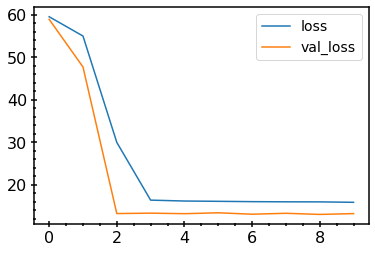

In [38]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(units=32, activation='relu', input_shape=dc_dataset.X.shape[1:]),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'), 
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'), 
    layers.Dropout(0.2),
    layers.Dense(units=1),
])
model.compile(loss='mae', optimizer='adam')

print(model.summary())

history = model.fit(
    train.X, train.y,
    validation_data=(test.X,test.y),
    batch_size=24,
    epochs=10,
)

## perform a plot of loss vs epochs 
import matplotlib.pyplot as plt
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# TODO 
-how to use a DeepChemKeras Model to perform the fit  
-there is a better architecture  of the NN ? 

In [157]:
dc_model = dc.models.KerasModel(model,dc.metrics.mae_score)

# Examples of  Classic ML models 

In [41]:
from deepchem import splits
splitter = splits.RandomSplitter()
train, test  = splitter.train_test_split(dc_dataset,seed=42)

In [46]:
train.X.shape

(1012, 4564, 21)

# TODO
-how to reshape train.X to introduce it in to a ML model using DeepChem 

In [47]:
from sklearn.ensemble import RandomForestRegressor
from deepchem.utils.evaluate import Evaluator
import pandas as pd
seed = 42 # Set a random seed to get stable results
sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
sklearn_model.random_state = seed
model = dc.models.SklearnModel(sklearn_model)
model.fit(train)

ValueError: Found array with dim 3. Estimator expected <= 2.

# Finally, we will compare others descriptros such as AAcomposition and Composition,transition and distribution of AA (https://www.pnas.org/content/92/19/8700)  

In [48]:
from propy import PyPro

In [49]:
aaComplist = []
CTDList =[]
for seq in seq_list:
    Obj = PyPro.GetProDes(seq)
    aaComplist.append(np.array(list(Obj.GetAAComp().values())))
    CTDList.append(np.array(list(Obj.GetCTD().values())))

In [50]:
dc_dataset_aacomp = dc.data.NumpyDataset(X=aaComplist,y= temp)
dc_dataset_ctd = dc.data.NumpyDataset(X=CTDList,y= temp)

# Using clasic ML with the aacomosition featurizer 

In [51]:
from deepchem import splits
splitter = splits.RandomSplitter()
train, test  = splitter.train_test_split(dc_dataset_aacomp,seed=42)
from sklearn.ensemble import RandomForestRegressor
from deepchem.utils.evaluate import Evaluator
import pandas as pd
print("RandomForestRegressor")
seed = 42 # Set a random seed to get stable results
sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
sklearn_model.random_state = seed
model = dc.models.SklearnModel(sklearn_model)
model.fit(train)
metric = dc.metrics.Metric(dc.metrics.mae_score)
train_score = model.evaluate(train, [metric])
test_score = model.evaluate(test, [metric])
print("Train score is : {}".format(train_score))
print("Test score is : {}".format(test_score))
print("SupportVectorMachineRegressor")
from sklearn.svm import SVR
svr_sklearn = SVR(kernel="poly",degree=4)
svr_sklearn.random_state = seed 
model = dc.models.SklearnModel(svr_sklearn)
model.fit(train)
metric = dc.metrics.Metric(dc.metrics.mae_score)
train_score = model.evaluate(train, [metric])
test_score = model.evaluate(test, [metric])
print("Train score is : {}".format(train_score))
print("Test score is : {}".format(test_score))

RandomForestRegressor
Train score is : {'mae_score': 2.618318289893296}
Test score is : {'mae_score': 6.424065900477471}
SupportVectorMachineRegressor
Train score is : {'mae_score': 6.915117936487243}
Test score is : {'mae_score': 8.42955281366753}


In [52]:
from deepchem import splits
splitter = splits.RandomSplitter()
train, test  = splitter.train_test_split(dc_dataset_ctd,seed=42)
from sklearn.ensemble import RandomForestRegressor
from deepchem.utils.evaluate import Evaluator
import pandas as pd
print("RandomForestRegressor")
seed = 42 # Set a random seed to get stable results
sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
sklearn_model.random_state = seed
model = dc.models.SklearnModel(sklearn_model)
model.fit(train)
metric = dc.metrics.Metric(dc.metrics.mae_score)
train_score = model.evaluate(train, [metric])
test_score = model.evaluate(test, [metric])
print("Train score is : {}".format(train_score))
print("Test score is : {}".format(test_score))
print("SupportVectorMachineRegressor")
from sklearn.svm import SVR
svr_sklearn = SVR(kernel="poly",degree=4)
svr_sklearn.random_state = seed 
model = dc.models.SklearnModel(svr_sklearn)
model.fit(train)
metric = dc.metrics.Metric(dc.metrics.mae_score)
train_score = model.evaluate(train, [metric])
test_score = model.evaluate(test, [metric])
print("Train score is : {}".format(train_score))
print("Test score is : {}".format(test_score))

RandomForestRegressor
Train score is : {'mae_score': 2.572226988614976}
Test score is : {'mae_score': 6.987328441471036}
SupportVectorMachineRegressor
Train score is : {'mae_score': 12.2357520685622}
Test score is : {'mae_score': 12.083711912061512}
